# Markov model of the inputs

Objective: find a stochastic model for the two uncertain inputs of the solar home:

* $P_{load}$: the power demand of the house
* $P_{sun}$: the available solar power

These two inputs could be modeled separately, but since this model will be used by a Dynamic Programming based energy management, we are limited by the curse of dimensionality. So we will model the *net load*:

$$P_{nl}= P_{load} - P_{sun}$$

For the same reason, we will search for a Markov model (i.e. state space model) of low dimension (1), that is a first order autoregressive model. The model could be non linear:

$$ P_{nl}(k+1) = f(P_{nl}(k), \varepsilon(k+1), h(k+1)) $$

where:

* $h$ is an external regressor: the hour of the day ($0 \leq h < 24$)
* $\varepsilon$ is an iid process.

Maybe a dependency on the previous day may help model the strong persistence between days.

Other reason for low dimensionality: model needs to be trained with a limited data history (~30 days) due to the non stationarity along the year (e.g. the sun power).

#### Comparison of the aggregated model with two separate models:

* benefits:

  * lower dimension
  * possibly more gaussianity ?
* drawbacks: 

  * no theoretical support, i.e. if $P_{load}$ and $P_{sun}$ were Markov, $P_{nl}$ wouldn't be necessarily Markov as well. However, the Markov property of $P_{load}$ and $P_{sun}$ is not guaranteed either...
  * impossible to disagregate

## Load testcase data — training set


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
P_pvp = 3 # kW

In [3]:
df = pd.read_csv('../data/data_2011-2012.csv', index_col=0, parse_dates=True)
dt = 0.5 # hours

sl = slice('2011-10-29','2011-11-28')
df = df[sl]
df.head(3)

,GC,GG
2011-10-29 00:00:00,0.390,0.0
2011-10-29 00:30:00,0.378,0.0
2011-10-29 01:00:00,0.342,0.0


In [4]:
df.tail(3)

,GC,GG
2011-11-28 22:30:00,0.542,0.0
2011-11-28 23:00:00,0.558,0.0
2011-11-28 23:30:00,0.500,0.0


Compute "net load": $P_{nl}= P_{load} - P_{sun}$

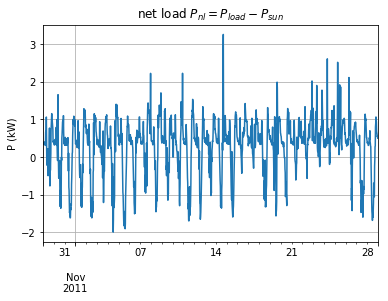

In [5]:
P_load = df.GC
P_sun = df.GG/1.04*P_pvp;

P_nl = P_load - P_sun
ax = P_nl.plot()
ax.set(ylabel='P (kW)', title="net load $P_{nl}= P_{load} - P_{sun}$")
plt.grid()

zoom on 6 days

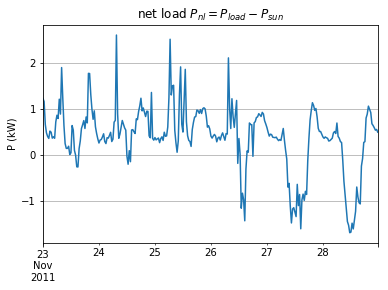

In [6]:
ax = P_nl['2011-11-23':].plot()
ax.set(ylabel='P (kW)', title="net load $P_{nl}= P_{load} - P_{sun}$")
plt.grid()

## Distribution: histogram, quantiles

In [7]:
P_nl.describe()

count    1488.000000
mean        0.286681
std         0.724291
min        -1.991308
25%         0.043885
50%         0.409000
75%         0.718981
max         3.252077
dtype: float64

In [8]:
Pm = P_nl.mean()

### Marginal distribution

interesting, but pretty misleading given the strong seasonality

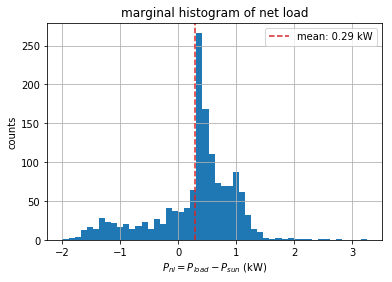

In [9]:
ax = P_nl.hist(bins=50)
ax.axvline(Pm, color='tab:red', ls='--', label='mean: %.2f kW' % Pm)
ax.legend()
ax.set(
    xlabel='$P_{nl}= P_{load} - P_{sun}$ (kW)',
    ylabel='counts',
    title='marginal histogram of net load'
);

log histogram

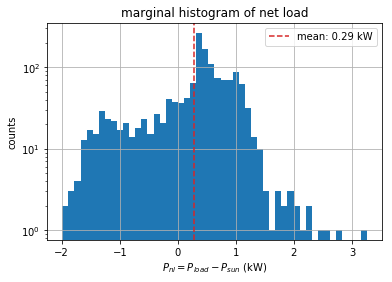

In [10]:
ax = P_nl.hist(bins=50)
ax.axvline(Pm, color='tab:red', ls='--', label='mean: %.2f kW' % Pm)
ax.legend()
ax.set(
    xlabel='$P_{nl}= P_{load} - P_{sun}$ (kW)',
    ylabel='counts',
    yscale='log',
    title='marginal histogram of net load'
);

cumulative distribution

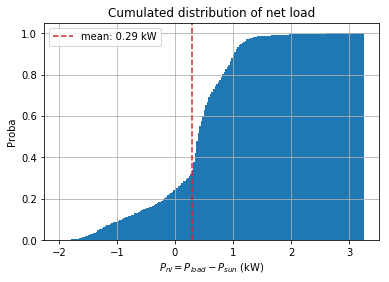

In [11]:
ax = P_nl.hist(bins=200, cumulative=True, density=True)
ax.axvline(Pm, color='tab:red', ls='--', label='mean: %.2f kW' % Pm)
ax.legend()
ax.set(
    xlabel='$P_{nl}= P_{load} - P_{sun}$ (kW)',
    ylabel='Proba',
    title='Cumulated distribution of net load'
);

## Temporal structure, persistence

In [12]:
def acf(x, lag_max):
    s = x.var()
    cov_xx = [x.cov(x.shift(h)) for h in range(lag_max+1)]
    return pd.Series(cov_xx)/s

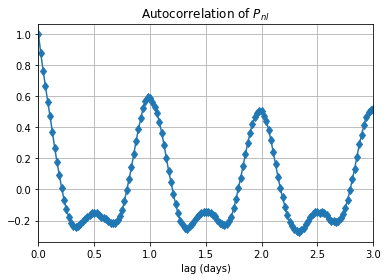

In [13]:
P_nl_acf = acf(P_nl, 48*3)
P_nl_acf.index = np.arange(len(P_nl_acf))*dt/24
ax = P_nl_acf.plot(style='-d')

ax.set(
    title = 'Autocorrelation of $P_{nl}$',
    xlabel = 'lag (days)'
)
plt.grid()

Looking at the autocorrelation, there is clearly a daily seasonality and persistence.

* because the daily periodic pattern (e.g. seasonality of the mean) ?
* or because of a persistence between days?

#### Daily average, to study the persitence between days

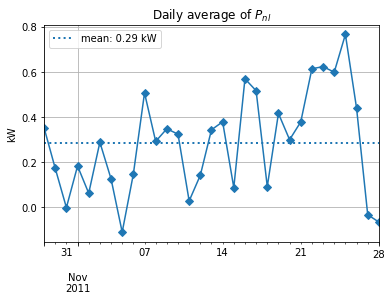

In [14]:
P_nl_d = P_nl.resample('1D').mean()
ax = P_nl_d.plot(style='D-', label='')
plt.axhline(Pm, ls=':', lw=2, label='mean: %.2f kW' % Pm)

ax.set(
    title = 'Daily average of $P_{nl}$',
    ylabel = 'kW'
)
ax.legend()
plt.grid()

44 % correlation between two consecutive days. So there is a medium persistence between consecutive days.

In [15]:
P_nl_d.corr(P_nl_d.shift())

0.4386780899122158

however, the precision of this number is small, because there are only 30 days. Cf. 95% the significence level

In [16]:
acf_sig = 1.96/np.sqrt(len(P_nl_d))
acf_sig

0.3520263919724788

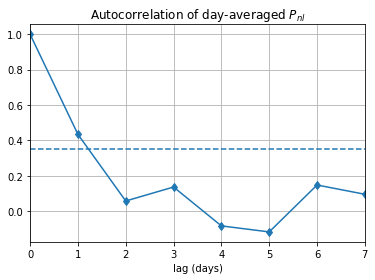

In [17]:
P_nl_d_acf = acf(P_nl_d, 7)
ax = P_nl_d_acf.plot(style='-d')
ax.axhline(acf_sig, ls='--')
#ax.axhline(-acf_sig, ls='--')
ax.set(
    title = 'Autocorrelation of day-averaged $P_{nl}$',
    xlabel = 'lag (days)'
)
plt.grid()

As a conclusion, the daily pattern may explain most of the acf pattern of  $P_{nl}$

## Daily pattern, deseasonalization

nb: some code here pasted from "Ausgrid Solar Home/Customer exploration" notebook.

In [18]:
def hod(tstamp):
    'hour of the day (fractional))'
    return tstamp.hour + tstamp.minute/60

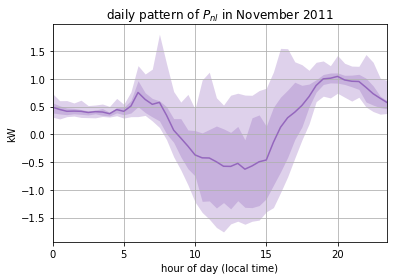

In [19]:
c = 'tab:purple'
P_byhod = P_nl.groupby(hod)
P_dm = P_byhod.mean()

ax = P_dm.plot(c=c)
ax.fill_between(P_dm.index, P_byhod.quantile(.05), P_byhod.quantile(.95),
                alpha=0.3, color=c, lw=0)
ax.fill_between(P_dm.index, P_byhod.quantile(.25), P_byhod.quantile(.75),
                alpha=0.3, color=c, lw=0)
ax.set(
    title='daily pattern of $P_{nl}$ in November 2011',
    ylabel='kW',
    xlabel='hour of day (local time)'
)
ax.grid()

plt.savefig('net-load_daily_pattern_2011-11.png',
            dpi=200, bbox_inches='tight')

### Modeling of the daily pattern

cf. [Input_daily_pattern.ipynb](Input_daily_pattern.ipynb) for the modeling of daily pattern and the non stationnary aspect